In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset


def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast


def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  dataset = dataset.batch(1).prefetch(1)

  return dataset


def seq2seq_windows_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

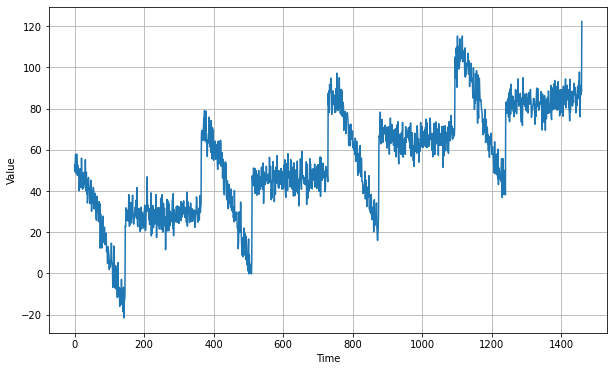

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

In [4]:
split_time = 1000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [5]:
len(x_train), len(x_valid)

(1000, 461)

# 1D Convolutional Layers

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = seq2seq_windows_dataset(x_train, WINDOW_SIZE, batch_size=128)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding='causal',
                           activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)                  
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 31ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 85.9241 - mae: 86.4234
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 82.4703 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 80.2434 - mae: 80.7428
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 72.4508 - mae: 72.9504
Epoch 10/100
8/8 [==============================] - 0s 30ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

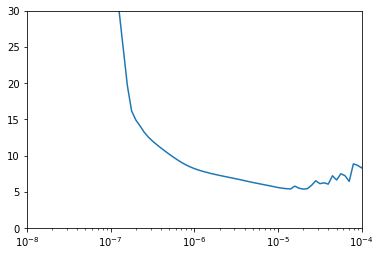

In [14]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = seq2seq_windows_dataset(x_train, WINDOW_SIZE, batch_size=128)
valid_set = seq2seq_windows_dataset(x_valid, WINDOW_SIZE, batch_size=128)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding='causal',
                           activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)                  
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                      save_best_onlu=True)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 155ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 46ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 48ms/step - loss: 17.3630 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 47ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 46ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 47ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 0s 47ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 45ms/step - 

In [16]:
model = tf.keras.models.load_model('model_checkpoint.h5')


In [17]:
cnn_forecast = model_forecast(model, series[:, np.newaxis], WINDOW_SIZE)
cnn_forecast = cnn_forecast[split_time - WINDOW_SIZE: -1, -1, 0]

In [18]:
cnn_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, cnn_forecast)
cnn_forecast_mae

<tf.Tensor: shape=(), dtype=float32, numpy=5.4096637>

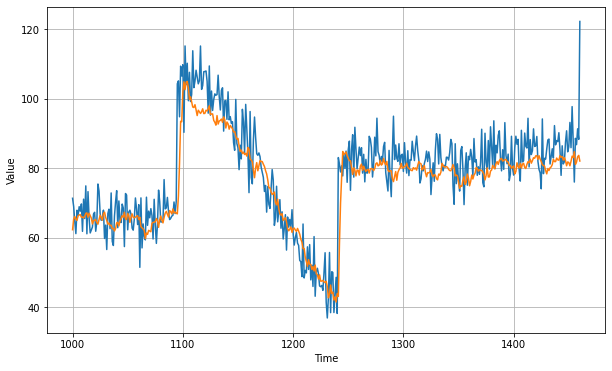

In [20]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, cnn_forecast)

# Fully Convolutional Forecasting

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 64
train_set = seq2seq_windows_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                             strides=1, padding='causal',
                             dilation_rate=dilation_rate,
                             activation='relu')
  )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch/30)
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 38ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 39ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 42ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 36.6836 - mae: 37.1823
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 0s 37ms/step - loss: 27.9450 - mae: 28.4427
Epoch 11/100
8/8 [==============================]

(0.0001, 0.1, 0.0, 30.0)

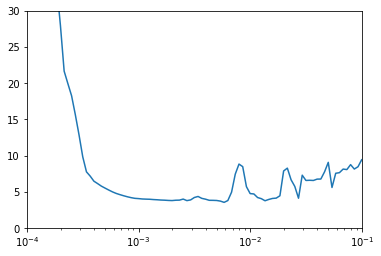

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 64
train_set = seq2seq_windows_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)
valid_set = seq2seq_windows_dataset(x_valid, window_size=WINDOW_SIZE, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                             strides=1, padding='causal',
                             dilation_rate=dilation_rate,
                             activation='relu')
  )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['mae']
)

history = model.fit(train_set,
                    epochs=500,
                    validation_data=valid_set,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 99ms/step - loss: 40.6342 - mae: 41.1331 - val_loss: 75.2768 - val_mae: 75.7768
Epoch 2/500
8/8 [==============================] - 1s 57ms/step - loss: 40.0937 - mae: 40.5925 - val_loss: 74.1500 - val_mae: 74.6499
Epoch 3/500
8/8 [==============================] - 1s 57ms/step - loss: 39.4584 - mae: 39.9572 - val_loss: 72.8124 - val_mae: 73.3124
Epoch 4/500
8/8 [==============================] - 1s 55ms/step - loss: 38.6988 - mae: 39.1975 - val_loss: 71.2066 - val_mae: 71.7066
Epoch 5/500
8/8 [==============================] - 1s 55ms/step - loss: 37.7869 - mae: 38.2857 - val_loss: 69.2875 - val_mae: 69.7875
Epoch 6/500
8/8 [==============================] - 1s 56ms/step - loss: 36.7073 - mae: 37.2057 - val_loss: 66.9977 - val_mae: 67.4977
Epoch 7/500
8/8 [==============================] - 1s 57ms/step - loss: 35.4190 - mae: 35.9178 - val_loss: 64.3133 - val_mae: 64.8133
Epoch 8/500
8/8 [==============================] - 1s 55ms/ste

In [35]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [38]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], WINDOW_SIZE)
cnn_forecast = cnn_forecast[split_time - WINDOW_SIZE:-1, -1, 0]

In [39]:
cnn_forecast.shape

(461,)

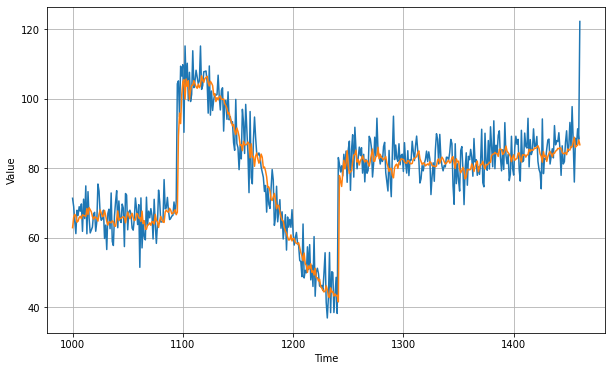

In [40]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, cnn_forecast)

In [41]:
cnn_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, cnn_forecast)
cnn_forecast_mae

<tf.Tensor: shape=(), dtype=float32, numpy=4.54622>